<a href="https://colab.research.google.com/github/hypro2/hands-on-langchain/blob/main/langchain-tutorial-part-3-OpenAI-function-agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

실습 자료 출처 :

랭체인 CEO의 깃허브 레포지토리

https://github.com/hwchase17/ai-engineer


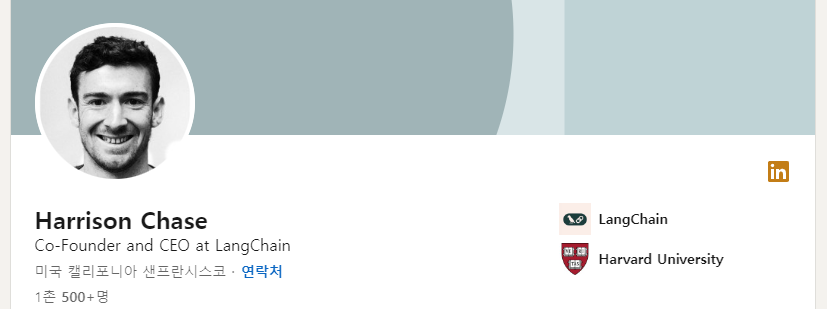

# OpenAI Function Calling In LangChain


In [1]:
!pip install -q langchain==0.1.0
!pip install -q openai
!pip install -q -U langchain-openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.0/798.0 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.7/226.7 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requi

In [2]:
import os
import getpass


try:
    from google.colab import userdata
    openai_api_key = userdata.get('OPENAI_API_KEY')
except:
    openai_api_key = os.getenv('OPENAI_API_KEY', getpass.getpass("입력해주세요."))

## Pydantic to OpenAI function definition


구성 함수인 'WeatherSearch'에 대한 Pydantic 데이터 클래스를 정의해 보겠습니다.

이 함수는 구성된 날씨 API 호출에 필요한 매개변수 집합을 반환합니다.

개발할 때, 딕셔너리를 통한 형식보다 Pydantic 데이터 클래스가 관리하기 편리합니다.

현재 버전에서는 pydantic.v1을 기준으로 작성되고 있습니다.

In [3]:
from typing import List
from pydantic.v1 import BaseModel, Field

In [4]:
# 구 버전
from langchain.utils.openai_functions import convert_pydantic_to_openai_function

# 신규 버전
from langchain_core.utils.function_calling import convert_to_openai_function

In [5]:
class WeatherSearch(BaseModel):
    """Call this with an airport code to get the weather at that airport""" # ```은 description에 해당합니다.
    airport_code: str = Field(description="airport code to get weather for") # 변수는 key, 필드는 value가 됩니다.

Openai를 이용하기 위해서는 pydantic 구조를 바로 쓰지는 못하고 변환이 필요하는 과정이 필요합니다.

convert_pydantic_to_openai_function을 이용해서 pydantic구조를 openai function구조로 변경해줍니다.

In [6]:
WeatherSearch.schema()

{'title': 'WeatherSearch',
 'description': 'Call this with an airport code to get the weather at that airport',
 'type': 'object',
 'properties': {'airport_code': {'title': 'Airport Code',
   'description': 'airport code to get weather for',
   'type': 'string'}},
 'required': ['airport_code']}

In [7]:
weather_function = convert_to_openai_function(WeatherSearch)
weather_function

{'name': 'WeatherSearch',
 'description': 'Call this with an airport code to get the weather at that airport',
 'parameters': {'type': 'object',
  'properties': {'airport_code': {'description': 'airport code to get weather for',
    'type': 'string'}},
  'required': ['airport_code']}}

OpenAI의 function calling에서 description은 필수 사항입니다.

pydentic 데이터 클래스에서는 """ """ 속 설명이 description에 해당합니다.

In [8]:
# We require it have a description
class WeatherSearch1(BaseModel):
    airport_code: str = Field(description="airport code to get weather for")

convert_pydantic_to_openai_function(WeatherSearch1)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `convert_pydantic_to_openai_function` was deprecated in LangChain 0.1.16 and will be removed in 0.2.0. Use langchain_core.utils.function_calling.convert_to_openai_function() instead.
  warn_deprecated(


{'name': 'WeatherSearch1',
 'description': '',
 'parameters': {'type': 'object',
  'properties': {'airport_code': {'description': 'airport code to get weather for',
    'type': 'string'}},
  'required': ['airport_code']}}

In [9]:
from langchain_openai  import ChatOpenAI

In [10]:
model = ChatOpenAI(openai_api_key=openai_api_key)
model.invoke("What is the weather in San Francisco right now?",
             functions=[weather_function])

AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"airport_code":"SFO"}', 'name': 'WeatherSearch'}})

In [11]:
model_with_function = model.bind(functions=[weather_function])

In [12]:
model_with_function.invoke("What is the weather in San Francisco right now?")

AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"airport_code":"SFO"}', 'name': 'WeatherSearch'}})

## Forcing it to use a function

bind을 통해 function을 넣어주면 모델을 불러올때 함수를 사용하도록 할  수있습니다.

function call을 지정해줘서 사용하도록 강제할 수 있습니다.

In [13]:
model_forced_function = model.bind(functions=[weather_function], function_call={"name":"WeatherSearch"})

In [14]:
model_forced_function.invoke("What is the weather in San Francisco right now?")

AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"airport_code":"SFO"}', 'name': 'WeatherSearch'}})

## Using in a chain

평소처럼 체인에서 작동하도록 바인딩된 이 모델을 사용할 수 있습니다.

In [15]:
from langchain.prompts import ChatPromptTemplate

In [16]:
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "You are a helfpul assistant"),
        ("user", "{input}")
    ]
)


In [17]:
chain = prompt | model_forced_function

In [18]:
chain.invoke({"input": "What is the weather in San Francisco right now?"})

AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"airport_code":"SFO"}', 'name': 'WeatherSearch'}})

## Using multiple functions

이보다 더 좋은 방법은 함수 집합을 전달하고 LLM이 질문 컨텍스트에 따라 어떤 함수를 사용할지 결정하도록 하는 것입니다.

In [19]:
class ArtistSearch(BaseModel):
    """Call this to get the names of songs by a particular artist"""

    artist_name: str = Field(description="name of artist to look up")
    n: int = Field(description="number of results")

In [20]:
convert_to_openai_function(ArtistSearch)

{'name': 'ArtistSearch',
 'description': 'Call this to get the names of songs by a particular artist',
 'parameters': {'type': 'object',
  'properties': {'artist_name': {'description': 'name of artist to look up',
    'type': 'string'},
   'n': {'description': 'number of results', 'type': 'integer'}},
  'required': ['artist_name', 'n']}}

In [21]:
model = ChatOpenAI(openai_api_key=openai_api_key)

functions = [
    convert_to_openai_function(WeatherSearch),
    convert_to_openai_function(ArtistSearch),
]

model_with_functions = model.bind(functions=functions)

In [22]:
model_with_functions.invoke("What is the weather in SF?")

AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"airport_code":"SFO"}', 'name': 'WeatherSearch'}})

In [23]:
model_with_functions.invoke("What are three songs by Taylor swift?")

AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"artist_name":"Taylor Swift","n":3}', 'name': 'ArtistSearch'}})

# Tagging and Extraction Using OpenAI functions

## 태깅
이전에는 함수(Function)를 사용하여 자연어 입력에서 특정 API 매개변수를 추출했습니다.

여기서는 함수(Function)가 매우 유연하다는 것을 보여줍니다.

함수(Function)를 사용하여 텍스트에 특정 정보를 쉽게 태그할 수 있습니다.

In [24]:
class Tagging(BaseModel):
    """Tag the piece of text with particular info."""
    sentiment: str = Field(description="sentiment of text, should be `pos`, `neg`, or `neutral`")
    language: str = Field(description="language of text (should be ISO 639-1 code)")

In [25]:
convert_to_openai_function(Tagging)

{'name': 'Tagging',
 'description': 'Tag the piece of text with particular info.',
 'parameters': {'type': 'object',
  'properties': {'sentiment': {'description': 'sentiment of text, should be `pos`, `neg`, or `neutral`',
    'type': 'string'},
   'language': {'description': 'language of text (should be ISO 639-1 code)',
    'type': 'string'}},
  'required': ['sentiment', 'language']}}

In [26]:
from langchain.prompts import ChatPromptTemplate
from langchain_openai  import ChatOpenAI

model = ChatOpenAI(temperature=0,openai_api_key=openai_api_key)
tagging_functions = [convert_to_openai_function(Tagging)]

prompt = ChatPromptTemplate.from_messages([
    ("system", "Think carefully, and then tag the text as instructed."),
    ("human", "{input}"),
])

# We pass function_call to MAKE it call this function
model_with_functions = model.bind(functions=tagging_functions, function_call={"name":"Tagging"})

tagging_chain = prompt | model_with_functions

tagging_chain.invoke({"input": "I love LangChain"})

AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"sentiment":"pos","language":"en"}', 'name': 'Tagging'}})

In [27]:
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser

In [28]:
tagging_chain = prompt | model_with_functions | JsonOutputFunctionsParser()

tagging_chain.invoke({"input": "non mi piace questo cibo"}) # 난 음식을 좋아하지 않아요

{'sentiment': 'neg', 'language': 'it'}

## 추출
추출은 태깅과 유사하지만 여러 정보를 추출하는 데 사용됩니다.

Pydantic 데이터 클래스를 결합해서 함수(Function)를 복합적으로 만들 수 있습니다.

In [29]:
from typing import Optional

class Person(BaseModel):
    """Information about a person."""
    name: str = Field(description="person's name")
    age: Optional[int] = Field(description="person's age")

class Information(BaseModel):
    """Information to extract."""
    people: List[Person] = Field(description="List of info about people")

In [30]:
convert_pydantic_to_openai_function(Information)

{'name': 'Information',
 'description': 'Information to extract.',
 'parameters': {'type': 'object',
  'properties': {'people': {'description': 'List of info about people',
    'type': 'array',
    'items': {'description': 'Information about a person.',
     'type': 'object',
     'properties': {'name': {'description': "person's name", 'type': 'string'},
      'age': {'description': "person's age", 'type': 'integer'}},
     'required': ['name']}}},
  'required': ['people']}}

In [31]:
convert_to_openai_function(Information)

{'name': 'Information',
 'description': 'Information to extract.',
 'parameters': {'type': 'object',
  'properties': {'people': {'description': 'List of info about people',
    'type': 'array',
    'items': {'description': 'Information about a person.',
     'type': 'object',
     'properties': {'name': {'description': "person's name", 'type': 'string'},
      'age': {'description': "person's age", 'type': 'integer'}},
     'required': ['name']}}},
  'required': ['people']}}

In [32]:
from langchain.output_parsers.openai_functions import JsonKeyOutputFunctionsParser
from langchain.prompts import ChatPromptTemplate

In [33]:
prompt = ChatPromptTemplate.from_messages([
    ("system", "Extract the relevant information, if not explicitly provided do not guess. Extract partial info"),
    ("human", "{input}")
])

extraction_functions = [convert_pydantic_to_openai_function(Information)]
extraction_model = model.bind(functions=extraction_functions, function_call={"name":"Information"})

extraction_chain = prompt | extraction_model | JsonKeyOutputFunctionsParser(key_name="people")
extraction_chain.invoke({"input": "Joe is 30. Joe's mom is Martha"})

[{'name': 'Joe', 'age': 30}, {'name': 'Martha'}]

#  Tool

이전에는 OpenAI 모델에 함수(Function)를 제공하는 방법을 보여드렸습니다.

함수(Function)는 작업(예: 추출, 태그 지정)이나 **API에 필요한 출력 스키마**를 지정하는 데 사용할 수 있습니다.

도구는 보다 일반적인 개념으로 LLM 에이전트의 중심 개념입니다.

종종 도구는 LLM이 쉽게 액세스할 수 있도록 API를 래핑합니다.

_

**도구는 LLM을 이용해서 도구에 들어갈 Input을 찾는 작업!**

In [34]:
from langchain.agents import tool

In [35]:
@tool
def search(query: str) -> str:
    """Search for the weather online."""
    return "result"

In [36]:
search.name

'search'

In [37]:
search.description

'search(query: str) -> str - Search for the weather online.'

In [38]:
search.args

{'query': {'title': 'Query', 'type': 'string'}}

도구에 사용할 Input을 LLM을 통해서 찾아 정의하는 것!!

description과 search.args을 통해서 정의

In [39]:
from pydantic.v1 import BaseModel, Field
from langchain_core.utils.function_calling import convert_to_openai_function
class SearchInput(BaseModel):
    query: str = Field(description="Thing to search for")

@tool(args_schema=SearchInput)
def search(query: str) -> str:
    """Search for the weather online."""
    return "result"

from langchain.tools.render import format_tool_to_openai_function

# format_tool_to_openai_function(search)
convert_to_openai_function(search)

{'name': 'search',
 'description': 'search(query: str) -> str - Search for the weather online.',
 'parameters': {'type': 'object',
  'properties': {'query': {'description': 'Thing to search for',
    'type': 'string'}},
  'required': ['query']}}

In [40]:
search.run("sf")

'result'

### 온도 도구
(경도,위도)만 있으면 온도 찾아주는 툴

우리가 필요한 것은 경도와 위도 이다. 온도는 도구에서 찾아줄 것이기 때문에


In [41]:
import requests
from pydantic.v1 import BaseModel, Field
import datetime

# Define the input schema
class OpenMeteoInput(BaseModel):
    latitude: float = Field(..., description="Latitude of the location to fetch weather data for")
    longitude: float = Field(..., description="Longitude of the location to fetch weather data for")

@tool(args_schema=OpenMeteoInput)
def get_current_temperature(latitude: float, longitude: float) -> dict:
    """Fetch current temperature for given coordinates."""

    BASE_URL = "https://api.open-meteo.com/v1/forecast"

    # Parameters for the request
    params = {
        'latitude': latitude,
        'longitude': longitude,
        'hourly': 'temperature_2m',
        'forecast_days': 1,
    }

    # Make the request
    response = requests.get(BASE_URL, params=params)

    if response.status_code == 200:
        results = response.json()
    else:
        raise Exception(f"API Request failed with status code: {response.status_code}")

    current_utc_time = datetime.datetime.utcnow()
    time_list = [datetime.datetime.fromisoformat(time_str.replace('Z', '+00:00')) for time_str in results['hourly']['time']]
    temperature_list = results['hourly']['temperature_2m']

    closest_time_index = min(range(len(time_list)), key=lambda i: abs(time_list[i] - current_utc_time))
    current_temperature = temperature_list[closest_time_index]

    return f'The current temperature is {current_temperature}°C'

In [42]:
get_current_temperature.description

'get_current_temperature(latitude: float, longitude: float) -> dict - Fetch current temperature for given coordinates.'

In [43]:
format_tool_to_openai_function(get_current_temperature)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `format_tool_to_openai_function` was deprecated in LangChain 0.1.16 and will be removed in 0.2.0. Use langchain_core.utils.function_calling.convert_to_openai_function() instead.
  warn_deprecated(


{'name': 'get_current_temperature',
 'description': 'get_current_temperature(latitude: float, longitude: float) -> dict - Fetch current temperature for given coordinates.',
 'parameters': {'type': 'object',
  'properties': {'latitude': {'description': 'Latitude of the location to fetch weather data for',
    'type': 'number'},
   'longitude': {'description': 'Longitude of the location to fetch weather data for',
    'type': 'number'}},
  'required': ['latitude', 'longitude']}}

In [44]:
get_current_temperature({"latitude": 13, "longitude": 14})

'The current temperature is 19.1°C'

### 위키피디아 검색 도구


In [45]:
! pip install -q wikipedia

  Preparing metadata (setup.py) ... done


In [46]:
import wikipedia

@tool
def search_wikipedia(query: str) -> str:
    """Run Wikipedia search and get page summaries."""
    page_titles = wikipedia.search(query)
    summaries = []
    for page_title in page_titles[: 3]:
        try:
            wiki_page =  wikipedia.page(title=page_title, auto_suggest=False)
            summaries.append(f"Page: {page_title}\nSummary: {wiki_page.summary}")
        except:
            pass
    if not summaries:
        return "No good Wikipedia Search Result was found"
    return "\n\n".join(summaries)

In [ ]:
search_wikipedia.run({"query": "langchain?"})

'Page: LangChain\nSummary: LangChain is a framework designed to simplify the creation of applications using large language models (LLMs). As a language model integration framework, LangChain\'s use-cases largely overlap with those of language models in general, including document analysis and summarization, chatbots, and code analysis.\n\nPage: OpenAI\nSummary: OpenAI is a U.S. based artificial intelligence (AI) research organization founded in December 2015, researching artificial intelligence with the goal of developing "safe and beneficial" artificial general intelligence, which it defines as "highly autonomous systems that outperform humans at most economically valuable work".\nAs one of the leading organizations of the AI Spring, it has developed several large language models, advanced image generation models, and previously, released open-source models. Its release of ChatGPT has been credited with starting the artificial intelligence spring.The organization consists of the non-p

# Tool Function Calling

앞에서 만든 도구들을 함수를 통해서 챗지피티를 사용한다.

먼저, 도구를 통해서 Tool_input을 만들어야된다. Tool_input은 Tool의 인자로 들어가며 Tool의 값을 출력하게끔 도와준다.

Tool_input은 Route를 통해서 어떤 Tool에 들어가야될지 정해준다.

In [47]:
from langchain_openai  import ChatOpenAI
from langchain.schema.messages import HumanMessage
from langchain.prompts import ChatPromptTemplate
from langchain.tools.render import format_tool_to_openai_function


functions = [format_tool_to_openai_function(f) for f in [search_wikipedia, get_current_temperature]]

model = ChatOpenAI(temperature=0, openai_api_key=openai_api_key).bind(functions=functions)

In [48]:
functions

[{'name': 'search_wikipedia',
  'description': 'search_wikipedia(query: str) -> str - Run Wikipedia search and get page summaries.',
  'parameters': {'type': 'object',
   'properties': {'query': {'type': 'string'}},
   'required': ['query']}},
 {'name': 'get_current_temperature',
  'description': 'get_current_temperature(latitude: float, longitude: float) -> dict - Fetch current temperature for given coordinates.',
  'parameters': {'type': 'object',
   'properties': {'latitude': {'description': 'Latitude of the location to fetch weather data for',
     'type': 'number'},
    'longitude': {'description': 'Longitude of the location to fetch weather data for',
     'type': 'number'}},
   'required': ['latitude', 'longitude']}}]

In [49]:
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are helpful but sassy assistant"),
    ("user", "{input}"),
])

chain = prompt | model
chain.invoke({"input": "what is the weather in san francisco right now"})

AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"latitude":37.7749,"longitude":-122.4194}', 'name': 'get_current_temperature'}})

In [50]:
model.invoke("what is langchain")

AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"query":"Langchain"}', 'name': 'search_wikipedia'}})

In [51]:
from langchain.agents.output_parsers import OpenAIFunctionsAgentOutputParser

chain = prompt | model | OpenAIFunctionsAgentOutputParser()

result = chain.invoke({"input": "What is the weather in san francisco right now?"})
result

AgentActionMessageLog(tool='get_current_temperature', tool_input={'latitude': 37.7749, 'longitude': -122.4194}, log="\nInvoking: `get_current_temperature` with `{'latitude': 37.7749, 'longitude': -122.4194}`\n\n\n", message_log=[AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"latitude":37.7749,"longitude":-122.4194}', 'name': 'get_current_temperature'}})])

In [52]:
type(result)

langchain_core.agents.AgentActionMessageLog

In [53]:
result.tool

'get_current_temperature'

In [54]:
result.tool_input

{'latitude': 37.7749, 'longitude': -122.4194}

In [55]:
get_current_temperature(result.tool_input)

'The current temperature is 11.8°C'

In [56]:
result = chain.invoke({"input": "hi!"})
type(result)

langchain_core.agents.AgentFinish

In [57]:
result

AgentFinish(return_values={'output': 'Well, hello there! How can I assist you today?'}, log='Well, hello there! How can I assist you today?')

In [58]:
from langchain.schema.agent import AgentFinish

def route(result):
    if isinstance(result, AgentFinish):
        return result.return_values['output']

    else:
        tools = {
            "search_wikipedia": search_wikipedia,
            "get_current_temperature": get_current_temperature,
        }

        return tools[result.tool].run(result.tool_input)

In [59]:
chain = prompt | model | OpenAIFunctionsAgentOutputParser() | route

In [60]:
result = chain.invoke({"input": "What is the weather in san francisco right now?"})
result

'The current temperature is 11.8°C'

# 심화 (self study)

## Tool 에이전트 만들기

에이전트는 이전 상호 작용에 대해서는 아무것도 기억하지 못합니다.

즉, 후속 질문을 쉽게 요청할 수 없습니다. 메모리를 추가하여 문제를 해결합시다.

In [ ]:
from langchain.prompts import MessagesPlaceholder

propmt = ChatPromptTemplate.from_messages([
		("system", "You are helpful but sassy assistant"),
		("user", "{input}"),
		MessagesPlaceholder(variable_name="agent_scratchpad") # 메세지 리스트를 전달하는 공간
])

chain = prompt | model | OpenAIFunctionsAgentOutputParser()

result1 = chain.invoke({
    "input": "what is the weather is sf?",
    "agent_scratchpad": []
})
result1

AgentActionMessageLog(tool='get_current_temperature', tool_input={'latitude': 37.7749, 'longitude': -122.4194}, log="\nInvoking: `get_current_temperature` with `{'latitude': 37.7749, 'longitude': -122.4194}`\n\n\n", message_log=[AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{\n  "latitude": 37.7749,\n  "longitude": -122.4194\n}', 'name': 'get_current_temperature'}})])

In [ ]:
observation = get_current_temperature(result1.tool_input)
observation

'The current temperature is 10.5°C'

In [ ]:
from langchain.agents.format_scratchpad import format_to_openai_functions

result1.message_log # Agent action으로 나온 결과에 어떻게 도달했는지 알려주는 메시지

[AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{\n  "latitude": 37.7749,\n  "longitude": -122.4194\n}', 'name': 'get_current_temperature'}})]

In [ ]:
format_to_openai_functions([(result1, observation), ]) # 메시지와 observation의 튜플을 넘겨주고, 반복하기 때문에 컴마를 붙여줌 무슨소린지는 잘모르겟음

[AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{\n  "latitude": 37.7749,\n  "longitude": -122.4194\n}', 'name': 'get_current_temperature'}}),
 FunctionMessage(content='The current temperature is 10.5°C', name='get_current_temperature')]

In [ ]:
result2 = chain.invoke({
    "input": "what is the weather is sf?",
    "agent_scratchpad": format_to_openai_functions([(result1, observation)])
})

result2

AgentActionMessageLog(tool='get_current_temperature', tool_input={'latitude': 37.7749, 'longitude': -122.4194}, log="\nInvoking: `get_current_temperature` with `{'latitude': 37.7749, 'longitude': -122.4194}`\n\n\n", message_log=[AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{\n  "latitude": 37.7749,\n  "longitude": -122.4194\n}', 'name': 'get_current_temperature'}})])

In [ ]:
from langchain.prompts import MessagesPlaceholder

prompt = ChatPromptTemplate.from_messages([
    ("system", "You are helpful but sassy assistant"),
    ("user", "{input}"),
    MessagesPlaceholder(variable_name="agent_scratchpad")
])

chain = prompt | model | OpenAIFunctionsAgentOutputParser()

### RunnablePassthrough

이 코드는 `RunnablePassthrough`를 사용하여 새로운 키(`agent_scratchpad`)를 추가하고, 이 키에 대한 값을 설정한 다음, 새로운 체인(chain)에 연결하는 것 같습니다.

그리고 `|` 연산자를 사용하여 이 새로운 `RunnablePassthrough` 인스턴스를 기존의 체인에 연결하고 있습니다. 따라서, `agent_chain`에는 이전 체인(`chain`)에 새로운 `RunnablePassthrough`가 추가된 새로운 체인이 형성되게 됩니다.

In [ ]:
from langchain.schema.runnable import RunnablePassthrough

runnable_intermediate =  RunnablePassthrough.assign(agent_scratchpad = lambda x: format_to_openai_functions(x["intermediate_steps"]))

agent_chain = runnable_intermediate | chain

In [ ]:
from langchain.schema.agent import AgentFinish

def run_agent(user_input):

    intermediate_steps = []

    while True:

        result = agent_chain.invoke({
            "input": user_input,
            "intermediate_steps": intermediate_steps
        })

        print(result)
        print(type(result))

        if isinstance(result, AgentFinish):
            return result

        tool = {
            "search_wikipedia": search_wikipedia,
            "get_current_temperature": get_current_temperature,
        }[result.tool]

        observation = tool.run(result.tool_input)
        intermediate_steps.append((result, observation))

run_agent("what is the weather is sf?")

tool='get_current_temperature' tool_input={'latitude': 37.7749, 'longitude': -122.4194} log="\nInvoking: `get_current_temperature` with `{'latitude': 37.7749, 'longitude': -122.4194}`\n\n\n" message_log=[AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{\n  "latitude": 37.7749,\n  "longitude": -122.4194\n}', 'name': 'get_current_temperature'}})]
<class 'langchain_core.agents.AgentActionMessageLog'>
return_values={'output': 'The current temperature in San Francisco is 10.5°C.'} log='The current temperature in San Francisco is 10.5°C.'
<class 'langchain_core.agents.AgentFinish'>


AgentFinish(return_values={'output': 'The current temperature in San Francisco is 10.5°C.'}, log='The current temperature in San Francisco is 10.5°C.')

In [ ]:
from langchain.agents import AgentExecutor

tools = [get_current_temperature, search_wikipedia]

agent_executor = AgentExecutor(agent=agent_chain, tools=tools, verbose=True)

agent_executor.invoke({"input": "what is Langchain"})



> Entering new AgentExecutor chain...

Invoking: `search_wikipedia` with `{'query': 'Langchain'}`


Page: LangChain
Summary: LangChain is a framework designed to simplify the creation of applications using large language models (LLMs). As a language model integration framework, LangChain's use-cases largely overlap with those of language models in general, including document analysis and summarization, chatbots, and code analysis.



Page: OpenAI
Summary: OpenAI is an American artificial intelligence (AI) research organization consisting of the non-profit OpenAI, Inc. registered in Delaware and its for-profit subsidiary OpenAI Global, LLC. OpenAI researches artificial intelligence with the declared intention of developing "safe and beneficial" artificial general intelligence, which it defines as "highly autonomous systems that outperform humans at most economically valuable work". OpenAI has also developed several large language models, such as ChatGPT and GPT-4, as well as advanced 

{'input': 'what is Langchain',
 'output': 'I couldn\'t find specific information about "Langchain" in my search results. It\'s possible that Langchain is a less well-known term or a specific term used in a certain context. If you have any additional information or context about Langchain, I may be able to provide more assistance.'}

## Handle Tool Error

도구가 오류를 만나고 예외가 처리되지 않으면, 에이전트는 실행을 중단합니다. 에이전트가 계속 실행되길 원한다면 ToolException을 발생시키고 handle_tool_error를 해당하는 대로 설정할 수 있습니다.

ToolException이 발생하면, 에이전트는 작업을 멈추지 않고 도구의 handle_tool_error 변수에 따라 예외를 처리하며 처리 결과는 관측값으로 에이전트에 반환되며 빨간색으로 출력됩니다.

handle_tool_error를 True로 설정하거나 통일된 문자열 값으로 설정하거나 함수로 설정할 수 있습니다. 함수로 설정할 경우, 함수는 ToolException을 매개변수로 받고 str 값을 반환해야 합니다.

In [ ]:
from langchain.agents import AgentType, initialize_agent
from langchain.chat_models import ChatOpenAI
from langchain.tools import Tool
from langchain.tools.base import ToolException


# 직접 에러문을 생성해서 사용할 수 있음
def _handle_error(error: ToolException) -> str:
    return (
        "The following errors occurred during tool execution:"
        + error.args[0]
        + "Please try another tool."
    )


def search_tool1(s: str):
    raise ToolException("The search tool1 is not available.")


def search_tool2(s: str):
    raise ToolException("The search tool2 is not available.")


search_tool3 = search_wikipedia

In [ ]:
description = "useful for when you need to answer questions about current events.You should give priority to using it."
tools = [
    Tool.from_function(
        func=search_tool1,
        name="Search_tool1",
        description=description,
        handle_tool_error=True,
    ),
    Tool.from_function(
        func=search_tool2,
        name="Search_tool2",
        description=description,
        handle_tool_error=_handle_error,
    ),
    Tool.from_function(
        func=search_tool3.run,
        name="Search_tool3",
        description="useful for when you need to answer questions about current events",
    ),
]

agent = initialize_agent(
    tools,
    ChatOpenAI(temperature=0, openai_api_key=openai_api_key),
    # agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    agent=AgentType.OPENAI_FUNCTIONS,
    verbose=True,
)

In [ ]:
agent.run("Who is Leo DiCaprio's girlfriend?")



> Entering new AgentExecutor chain...

Invoking: `Search_tool1` with `Leo DiCaprio girlfriend`


The search tool1 is not available.
Invoking: `Search_tool2` with `Leo DiCaprio girlfriend`


The following errors occurred during tool execution:The search tool2 is not available.Please try another tool.
Invoking: `Search_tool3` with `Leo DiCaprio girlfriend`


Page: Leonardo DiCaprio
Summary: Leonardo Wilhelm DiCaprio (; Italian: [diˈkaːprjo]; born November 11, 1974) is an American actor and film producer. Known for his work in biographical and period films, he is the recipient of numerous accolades, including an Academy Award, a British Academy Film Award, and three Golden Globe Awards. As of 2019, his films have grossed over $7.2 billion worldwide, and he has been placed eight times in annual rankings of the world's highest-paid actors.
Born in Los Angeles, DiCaprio began his career in the late 1980s by appearing in television commercials. In the early 1990s, he had recurring roles in 

"According to the information I found, Leonardo DiCaprio's girlfriend is Camila Morrone. She is an American actress and model."

## Custom LLM Agent 만들어 보기

LLM 채팅 에이전트는 다음과 같은 네 가지 주요 구성 요소로 구성됩니다:

1. PromptTemplate: 언어 모델에 수행 할 작업을 지시하는 프롬프트 템플릿입니다.

2. ChatModel: 에이전트에 전원을 공급하는 언어 모델입니다.

3. stop시퀀스 :이 문자열을 찾 자마자 LLM에 생성을 중지하도록 지시합니다.

4. OutputParser: LLM 출력을 AgentAction 또는 AgentFinish 목적.

LLM 에이전트AgentExecutor 다음과 같은 루프로 생각할 수 있습니다

1. 사용자 입력 및 이전 단계를 에이전트 (이 경우 LLM 에이전트)에 전달합니다.

2. 에이전트가 AgentFinish, 그런 다음 사용자에게 직접 반환

3. 에이전트가 AgentAction, 그런 다음이를 사용하여 도구를 호출하고 Observation

4. 반복 AgentAction 과 Observation 요원까지 AgentFinish 리턴됩니다.

AgentFinish 사용자에게 다시 보낼 최종 메시지가 포함 된 응답입니다. 에이전트 실행을 종료하는 데 사용해야합니다.

https://python.langchain.com/docs/modules/agents/how_to/custom_llm_chat_agent

In [ ]:
from langchain.agents import Tool, AgentExecutor, LLMSingleActionAgent, AgentOutputParser
from langchain.prompts import BaseChatPromptTemplate
from langchain.chains.llm import LLMChain
from langchain.chat_models import ChatOpenAI
from typing import List, Union
from langchain.schema import AgentAction, AgentFinish, HumanMessage
import re
from langchain.agents.output_parsers import OpenAIFunctionsAgentOutputParser

In [ ]:
import wikipedia

@tool
def search_wikipedia(query: str) -> str:
    """Run Wikipedia search and get page summaries."""
    page_titles = wikipedia.search(query)
    summaries = []
    for page_title in page_titles[: 1]:
        try:
            wiki_page =  wikipedia.page(title=page_title, auto_suggest=False)
            summaries.append(f"Page: {page_title}\nSummary: {wiki_page.summary}")
        except:
            pass
    if not summaries:
        return "No good Wikipedia Search Result was found"
    return "\n\n".join(summaries)

In [ ]:
# LLM에게 템플리슬 통해 유도하는 방식으로 Function Calling을 쓰지않고 사용했지만, 예시기 때문에 안쓴거고 사실 쓰는 것이 좋음

template = """Complete the objective as best you can. You have access to the following tools:

{tools}

Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of [{tool_names}]
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question

These were previous tasks you completed:



Begin!

Question: {input}
{agent_scratchpad}"""

In [ ]:
class CustomPromptTemplate(BaseChatPromptTemplate):
    # The template to use
    template: str
    # The list of tools available
    tools: List[Tool]

    def format_messages(self, **kwargs) -> str:
        # 중간 단계(에이전트 작업, 관찰 튜플) 가져오기
        # 특정 방식으로 형식 지정
        intermediate_steps = kwargs.pop("intermediate_steps")

        thoughts = ""
        for action, observation in intermediate_steps:
            thoughts += action.log
            thoughts += f"\nObservation: {observation}\nThought: "

        # agent_scratchpad  변수를 해당 값으로 설정합니다.
        kwargs["agent_scratchpad"] = thoughts

        # 제공된 도구 목록에서 도구 변수를 만들기
        kwargs["tools"] = "\n".join([f"{tool.name}: {tool.description}" for tool in self.tools])

        # 제공된 도구의 도구 이름 목록 만들기
        kwargs["tool_names"] = ", ".join([tool.name for tool in self.tools])
        formatted = self.template.format(**kwargs)
        return [HumanMessage(content=formatted)]

In [ ]:
tools = [get_current_temperature, search_wikipedia]

In [ ]:
prompt = CustomPromptTemplate(
    template=template,
    tools=tools,
    # 여기에는 `agent_scratchpad`, `tools` 및 `tool_names` 변수는 동적으로 생성되므로 생략합니다.
    # 여기에는 `intermediate_steps` 변수가 필요하므로 포함됩니다.
    input_variables=["input", "intermediate_steps"]
)

In [ ]:
class CustomOutputParser(AgentOutputParser):

    def parse(self, llm_output: str) -> Union[AgentAction, AgentFinish]:

        # Check if agent should finish
        if "Final Answer:" in llm_output:
            return AgentFinish(
                # 반환 값은 일반적으로 항상 단일 `output` 키가 있는 딕셔너리입니다.
                # 현재로서는 다른 것을 시도하는 것은 권장하지 않습니다 :)
                return_values={"output": llm_output.split("Final Answer:")[-1].strip()},
                log=llm_output,
            )

        # 검색할 것 요소를 찾는다.
        regex = r"Action\s*\d*\s*:(.*?)\nAction\s*\d*\s*Input\s*\d*\s*:[\s]*(.*)"
        match = re.search(regex, llm_output, re.DOTALL)

        if not match:
            raise ValueError(f"Could not parse LLM output: `{llm_output}`")

        action = match.group(1).strip()
        action_input = match.group(2)

        # Return the action and action input
        return AgentAction(tool=action, tool_input=action_input.strip(" ").strip('"'), log=llm_output)

In [ ]:
output_parser = CustomOutputParser()

In [ ]:
llm = ChatOpenAI(openai_api_key=openai_api_key, temperature=0)

In [ ]:
llm_chain = LLMChain(llm=llm, prompt=prompt)

In [ ]:
tool_names = [tool.name for tool in tools]

agent = LLMSingleActionAgent(
    llm_chain=llm_chain,
    output_parser=output_parser,
    stop=["\nObservation:"],
    allowed_tools=tool_names
)

In [ ]:
agent_executor = AgentExecutor.from_agent_and_tools(agent=agent, tools=tools, verbose=True)

In [ ]:
agent_executor.run("what is langchain")



> Entering new AgentExecutor chain...
Thought: I don't know what "langchain" is, so I should search for it on Wikipedia.
Action: search_wikipedia
Action Input: "langchain"

Observation:Page: LangChain
Summary: LangChain is a framework designed to simplify the creation of applications using large language models (LLMs). As a language model integration framework, LangChain's use-cases largely overlap with those of language models in general, including document analysis and summarization, chatbots, and code analysis.
The Wikipedia search for "langchain" returned a page called "LangChain" which provides a summary of what it is.
Final Answer: LangChain is a framework designed to simplify the creation of applications using large language models.

> Finished chain.


'LangChain is a framework designed to simplify the creation of applications using large language models.'